# Oscillating masses

In this Jupyter Notebook we illustrate the example **oscillating_masses_discrete**.

**Open an interactive online Jupyter Notebook with this content on Binder:**

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/do-mpc/do-mpc.git/master?filepath=%2Fdocumentation%2Fsource%2Fexample_gallery%2Foscillating_masses_discrete.ipynb)

The example consists of the three modules **template_model.py**, which describes the system model, **template_mpc.py**, which defines the settings for the control and **template_simulator.py**, which sets the parameters for the simulator.
The modules are used in **main.py** for the closed-loop execution of the controller.
One exemplary result will be presented at the end of this tutorial as a gif.

In the following the different parts are presented. But first, we start by importing basic modules and **do-mpc**.

In [1]:
import numpy as np
import sys
from casadi import *

# Add do_mpc to path. This is not necessary if it was installed via pip
import os
rel_do_mpc_path = os.path.join('..','..','..')
sys.path.append(rel_do_mpc_path)

# Import do_mpc package:
import do_mpc

## Model

In the following we will present the configuration, setup and connection between these blocks, starting with the `model`.
The considered model are two horizontally oscillating masses interconnected via a spring where each one is connected via a spring to a wall, as shown below:

![SegmentLocal](oscillating_masses.png "segment")

The states of each mass are its position $s_i$ and velocity $v_i$, $i=1,2$.
A force $u_1$ can be applied to the right mass.
The via first-order hold and a sampling time of 0.5 seconds discretized model $x_{k+1} = A x_k + B u_k$ is given by:

$$
A = \begin{bmatrix} 0.763 & 0.460& 0.115& 0.020 \\ 
                    −0.899 & 0.763 & 0.420 & 0.115 \\
                     0.115 & 0.020 & 0.763 & 0.460 \\
                     0.420 & 0.115 & −0.899 & 0.763 \\ \end{bmatrix}, \qquad
                     B = \begin{bmatrix} 0.014 \\ 0.063 \\ 0.221 \\ 0.367 \\ \end{bmatrix},
$$

where $x = [s_1, v_1, s_2, v_2]^T$ and $u = [u_1]$.

The discrete model is initiated by:

In [2]:
model_type = 'discrete' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

### States and control inputs

The states and the inputs are directly created as vectors:

In [3]:
_x = model.set_variable(var_type='_x', var_name='x', shape=(4,1))
_u = model.set_variable(var_type='_u', var_name='u', shape=(1,1))

Afterwards the discrete-time LTI model is added:

In [4]:
A = np.array([[ 0.763,  0.460,  0.115,  0.020],
              [-0.899,  0.763,  0.420,  0.115],
              [ 0.115,  0.020,  0.763,  0.460],
              [ 0.420,  0.115, -0.899,  0.763]])

B = np.array([[0.014],
              [0.063],
              [0.221],
              [0.367]])

x_next = A@_x + B@_u

model.set_rhs('x', x_next)

Additionally, we will define an expression, which represents the stage and terminal cost of our control problem.
This term will be later used as the cost in the MPC formulation and can be used to directly plot the trajectory of the cost of each state.

In [5]:
model.set_expression(expr_name='cost', expr=sum1(_x**2))

SX((((sq(x_0)+sq(x_1))+sq(x_2))+sq(x_3)))

The model setup is completed via:

In [6]:
# Build the model
model.setup()

## Controller


Next, the model predictive controller is configured.
First, one member of the mpc class is generated with the prediction model defined above:

In [7]:
mpc = do_mpc.controller.MPC(model)

We choose the prediction horizon `n_horizon` to 7 and set the robust horizon `n_robust` to zero, because no uncertainties are present. The time step `t_step` is set to 0.5 seconds (like the discretization time step)).
There is no need to apply a discretization scheme, because the system is discrete:

In [8]:
setup_mpc = {
    'n_robust': 0,
    'n_horizon': 7,
    't_step': 0.5,
    'state_discretization': 'discrete',
    'store_full_solution':True,
    # Use MA27 linear solver in ipopt for faster calculations:
    #'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
}

mpc.set_param(**setup_mpc)

### Objective

The goal of the controller is to bring the system to the origin, hence we apply a quadratic cost with weight one to every state and penalty on input changes for a smooth operation.
This is here done by using the the cost expression defined in the model:

In [9]:
mterm = model.aux['cost'] # terminal cost
lterm = model.aux['cost'] # terminal cost
 # stage cost

mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(u=1e-4) # input penalty

### Constraints

In the next step, the constraints of the control problem are set.
In this case, there are only upper and lower bounds for each state and the input.
The displacement has to fulfill $-4\text{m} \leq s_i \leq 4\text{m}$, the velocity $-10 \text{ms}^{-1} \leq v_i \leq 10\text{ms}^{-1}$ and the force cannot exceed $-0.5\text{N} \leq u_1 \leq 0.5\text{N}$:

In [10]:
max_x = np.array([[4.0], [10.0], [4.0], [10.0]])

# lower bounds of the states
mpc.bounds['lower','_x','x'] = -max_x

# upper bounds of the states
mpc.bounds['upper','_x','x'] = max_x

# lower bounds of the input
mpc.bounds['lower','_u','u'] = -0.5

# upper bounds of the input
mpc.bounds['upper','_u','u'] =  0.5

The setup of the MPC controller is concluded by:

In [11]:
mpc.setup()

## Estimator

We assume, that all states can be directly measured (state-feedback):

In [12]:
estimator = do_mpc.estimator.StateFeedback(model)

## Simulator

To create a simulator in order to run the MPC in a closed-loop, we create an instance of the **do-mpc** simulator which is based on the same model:

In [13]:
simulator = do_mpc.simulator.Simulator(model)

Because the model is discrete, we do not need to specify options for the integration necessary for simulating the system.
We only set the time step `t_step` which is identical to the one used for the optimization and finish the setup of the simulator:

In [14]:
simulator.set_param(t_step = 0.1)
simulator.setup()

## Closed-loop simulation

For the simulation of the MPC configured for the oscillating masses, we inspect the file **main.py**.
We set the initial state of the system (randomly seeded) and set it for all parts of the closed-loop configuration:

In [15]:
# Seed
np.random.seed(99)

# Initial state
e = np.ones([model.n_x,1])
x0 = np.random.uniform(-3*e,3*e) # Values between +3 and +3 for all states
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0

# Use initial state to set the initial guess.
mpc.set_initial_guess()

Now, we simulate the closed-loop for 50 steps (and suppress the output of the cell with the magic command `%%capture`):

In [16]:
%%capture
for k in range(50):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

## Displaying the results

After some slight configuration of matplotlib:

In [17]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

We use the convenient ``default_plot`` function of the ``graphics`` module, to obtain the graphic below.

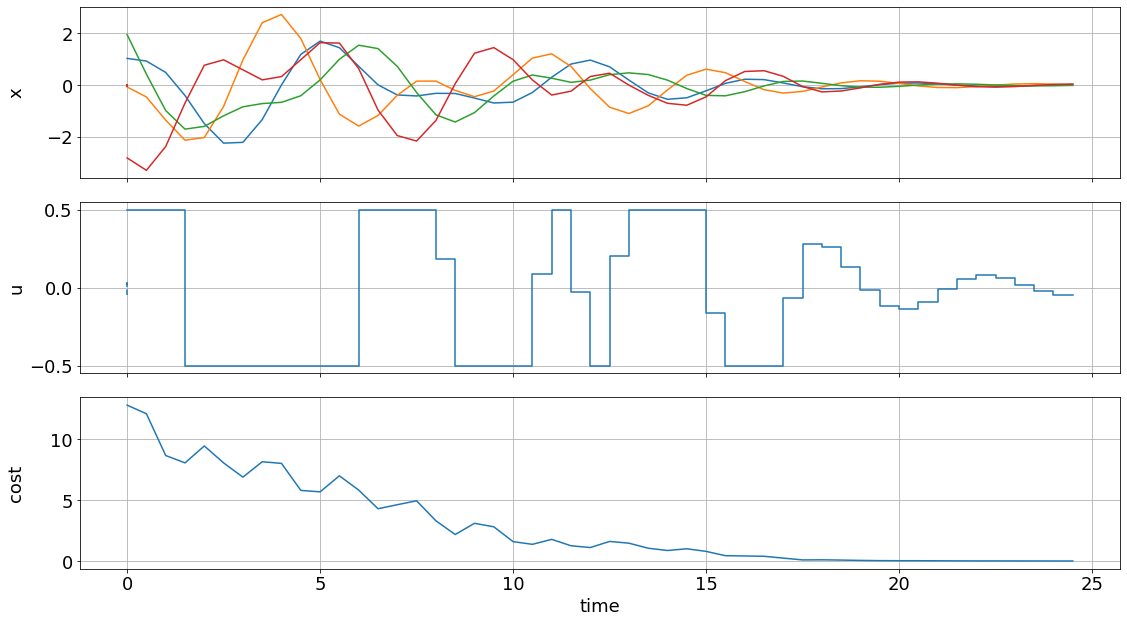

In [18]:
import matplotlib.pyplot as plt
fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()
plt.show()

We can see that the control objective was sucessfully fulfilled and that bounds, e.g. for the control inputs are satisfied. 